# Transfer learning to OASIS dataset

Using weights of models.resnet18

## Create train and val dataset
Divide OASIS images into **train** and **validation** datasets, with 75/25 ratio

We have total 900 images in OASIS dataset.

- train
 - negative
 - neutral
 - positive
- val 
 - negative
 - neutral
 - positive

In [1]:
import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import numpy as np
import matplotlib.pyplot as plt
import pprint
from matplotlib.pyplot import imshow
from PIL import Image
import os, os.path
import random
from shutil import copyfile
from shutil import rmtree
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

pp = pprint.PrettyPrinter(width=41, compact=True)
neutralHigh = 3.0
positiveLow = 5.0

trainValSplitRatio = 0.75


None


In [2]:
oasis_csv_path = "dataset/metadata/OASIS.csv"
oasis_images_src = "dataset/images/"
dataset_path = "dataset/grouped/"
dataset_groups=["train", "val"]
classes = ["negative", "neutral", "positive"]

rmtree(dataset_path, ignore_errors=True)

# Create corresponding folders
for dgroup in dataset_groups:
    for label in classes:
        directory = dataset_path+"/"+dgroup+"/"+label
        if not os.path.exists(directory):
            os.makedirs(directory)

oasis_df = dt.read_oasis_csv_into_dataframe(oasis_csv_path)
oasis_df.shape
oasis_df.head(1)
oasis_df = oasis_df[['id', 'theme', 'valence_mean']]
oasis_df.columns = ['id', 'image_name', 'valence_mean']


random.seed(1)

for index, row in oasis_df.iterrows():
    id = row['id']
    image_name = row['image_name']+".jpg"
    valence = row['valence_mean']
    label = sc.evaluate_score(valence,True,neutralHigh,positiveLow).lower()
    prob = random.uniform(0, 1)
    #print(id, image_name, valence, label,prob)
    dGroup = ""
    if prob > trainValSplitRatio:
        dGroup = "val"
    else:
        dGroup = "train"
    #print(prob >= trainValSplitRatio, dGroup)
    src = oasis_images_src+"/"+image_name
    dst = dataset_path+"/"+dGroup+"/"+label+"/"+image_name
    copyfile(src, dst)

print("Folder name", "\t\t\t","Image count")    
for dgroup in dataset_groups:
    for label in classes:
        folder = dataset_path+"/"+dgroup+"/"+label
        print(folder,"\t",len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name))]))    

Folder name 			 Image count
dataset/grouped//train/negative 	 110
dataset/grouped//train/neutral 	 312
dataset/grouped//train/positive 	 242
dataset/grouped//val/negative 	 53
dataset/grouped//val/neutral 	 108
dataset/grouped//val/positive 	 75


# Pytorch : Transfer Learning

In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = dataset_path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=6,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print("Classes:",class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Classes: ['negative', 'neutral', 'positive']


## Visualize few images

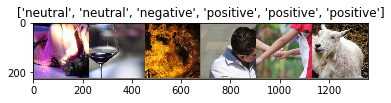

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let’s write a general function to train a model. Here, we will illustrate:

- Scheduling the learning rate
- Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

Generic function to display predictions for a few images

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(30,20))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                fig = plt.figure(figsize=(30,20))
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.

In [44]:
model_ft = models.resnet152(pretrained=True)
#print(model_ft)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.5, 0.999))
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


## Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [45]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0694 Acc: 0.4925
val Loss: 1.0108 Acc: 0.5466

Epoch 1/24
----------
train Loss: 1.0101 Acc: 0.5693
val Loss: 0.8507 Acc: 0.6398

Epoch 2/24
----------
train Loss: 0.8195 Acc: 0.6551
val Loss: 0.9272 Acc: 0.6186

Epoch 3/24
----------
train Loss: 0.7199 Acc: 0.7108
val Loss: 1.4801 Acc: 0.5212

Epoch 4/24
----------
train Loss: 0.6053 Acc: 0.7425
val Loss: 0.9877 Acc: 0.6822

Epoch 5/24
----------
train Loss: 0.6964 Acc: 0.7214
val Loss: 1.0496 Acc: 0.6356

Epoch 6/24
----------
train Loss: 0.6103 Acc: 0.7485
val Loss: 1.2340 Acc: 0.6271

Epoch 7/24
----------
train Loss: 0.5174 Acc: 0.7982
val Loss: 0.9796 Acc: 0.6314

Epoch 8/24
----------
train Loss: 0.4304 Acc: 0.8524
val Loss: 0.9083 Acc: 0.6610

Epoch 9/24
----------
train Loss: 0.4346 Acc: 0.8163
val Loss: 0.8990 Acc: 0.6525

Epoch 10/24
----------
train Loss: 0.3770 Acc: 0.8419
val Loss: 0.8929 Acc: 0.6525

Epoch 11/24
----------
train Loss: 0.3352 Acc: 0.8675
val Loss: 0.8821 Acc: 0.6441

Ep

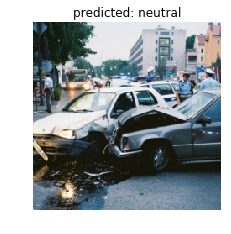

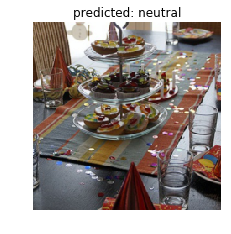

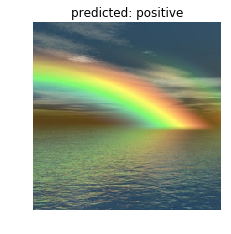

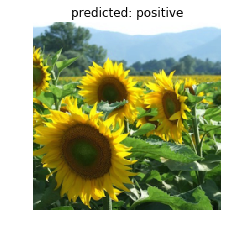

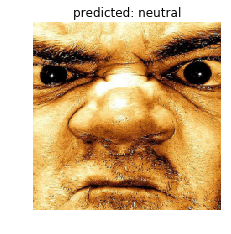

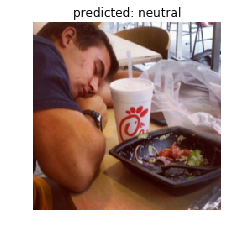

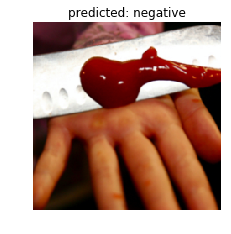

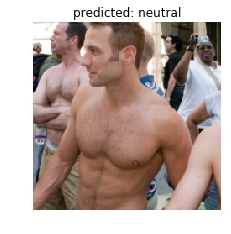

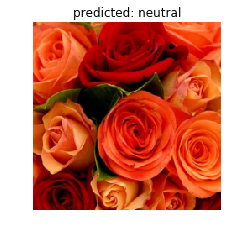

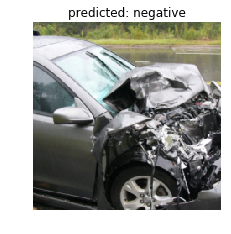

In [47]:
# Resnet 18: Training complete in 1m 10s Best val Acc: 0.635593 25 epoch
# Resnet 18: Training complete in 4m 53s Best val Acc: 0.661017 100 epoch
# Resnet 152: Training complete in 6m 33s Best val Acc: 0.694915
visualize_model(model_ft, num_images=10)

# 2. ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

In [58]:
import os
model_conv = torchvision.models.resnet152(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)
#print(model_conv)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [59]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0939 Acc: 0.4623
val Loss: 0.9098 Acc: 0.5508

Epoch 1/24
----------
train Loss: 0.9248 Acc: 0.5617
val Loss: 1.1135 Acc: 0.5339

Epoch 2/24
----------
train Loss: 0.9197 Acc: 0.5934
val Loss: 0.8573 Acc: 0.6144

Epoch 3/24
----------
train Loss: 0.8817 Acc: 0.5934
val Loss: 1.0119 Acc: 0.6017

Epoch 4/24
----------
train Loss: 0.8640 Acc: 0.6235
val Loss: 0.7813 Acc: 0.6314

Epoch 5/24
----------
train Loss: 0.8855 Acc: 0.6084
val Loss: 0.8133 Acc: 0.6314

Epoch 6/24
----------
train Loss: 0.9309 Acc: 0.6250
val Loss: 0.8177 Acc: 0.5975

Epoch 7/24
----------
train Loss: 0.6996 Acc: 0.6837
val Loss: 0.8156 Acc: 0.6144

Epoch 8/24
----------
train Loss: 0.7671 Acc: 0.6642
val Loss: 0.8156 Acc: 0.6059

Epoch 9/24
----------
train Loss: 0.7152 Acc: 0.6762
val Loss: 0.7938 Acc: 0.6398

Epoch 10/24
----------
train Loss: 0.6702 Acc: 0.7048
val Loss: 0.7986 Acc: 0.6229

Epoch 11/24
----------
train Loss: 0.7139 Acc: 0.6837
val Loss: 0.7826 Acc: 0.6271

Ep

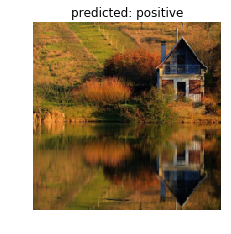

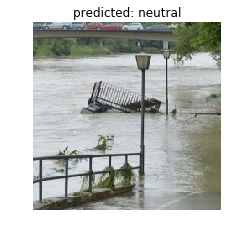

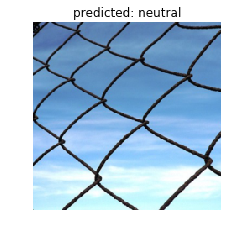

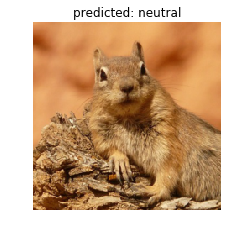

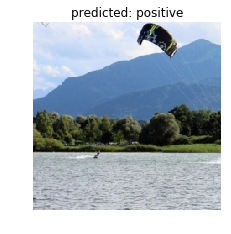

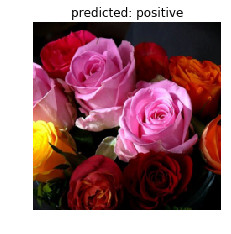

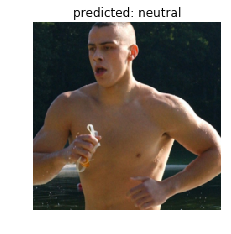

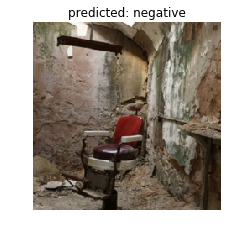

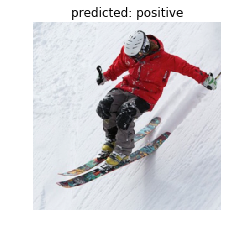

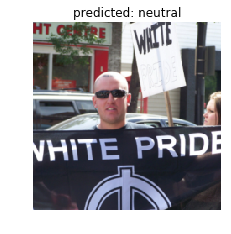

In [60]:
# Resnet18 Training complete in 0m 42s Best val Acc: 0.622881
# Resnet152 Training complete in 2m 8s Best val Acc: 0.652542
visualize_model(model_conv, num_images=10)

plt.ioff()
plt.show()

# Confusion Matrix

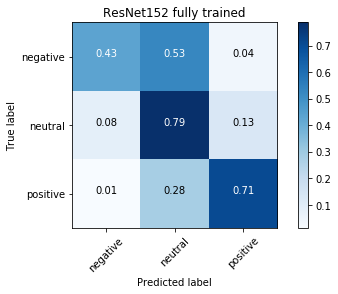

ResNet152 fully trained
{'f1_score_neg': 0.53, 'f1_score_neut': 0.7, 'f1_score_pos': 0.74}



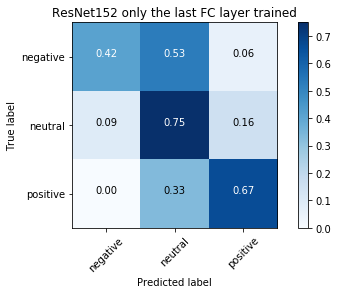

ResNet152 only the last FC layer trained
{'f1_score_neg': 0.52, 'f1_score_neut': 0.67, 'f1_score_pos': 0.69}


In [68]:
def confusion_matrix__model(model):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(30,20))
    trueLabels=[]
    predLabels=[]
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            trueLabels.extend(labels)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predLabels.extend(preds)
            #print("labels",labels)
            #print("preds",preds)
#             for j in range(inputs.size()[0]):
#                 images_so_far += 1
#                 fig = plt.figure(figsize=(30,20))
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title('predicted: {}'.format(class_names[preds[j]]))
#                 imshow(inputs.cpu().data[j])
        model.train(mode=was_training)
    return [trueLabels,predLabels]
    
trueLabels,predLabels = confusion_matrix__model(model_ft)    
title="ResNet152 fully trained"
pt.plot_confusion_matrix_from_labels(trueLabels,predLabels,title)
f1Score = sc.f1_score(trueLabels, predLabels, average=None)
print(title)
sc.print_f1_score(f1Score)
print()

trueLabels,predLabels = confusion_matrix__model(model_conv)    
title="ResNet152 only the last FC layer trained"
pt.plot_confusion_matrix_from_labels(trueLabels,predLabels,title)
f1Score = sc.f1_score(trueLabels, predLabels, average=None)
print(title)
sc.print_f1_score(f1Score)